### CONFIGURACAO AMBIENTE

In [19]:
# Importar as bibliotecas necessárias
import pandas as pd
import os
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Configurações do banco de dados
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT", 5432))



# Criar o engine de conexão usando SQLAlchemy
connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

# Criar uma conexão a partir do engine
connection = engine.raw_connection()


### DATA LOAD

In [20]:
# Carregar os dados da tabela de exportação
query = "SELECT * FROM exportacao;"
df_exportacao = pd.read_sql(query, con=connection)

# Fechar a conexão
connection.close()

# Visualizar os primeiros registros dos dados carregados
df_exportacao.head()


/tmp/ipykernel_244342/2683005586.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_exportacao = pd.read_sql(query, con=connection)


,id,ano,pais,quantidade_litros,valor_usd,data_insercao
0,2091,2016,Argélia,NaN,NaN,2025-04-02 17:28:14.107217
1,992,2016,Camarões,NaN,NaN,2025-03-30 18:29:37.303403
2,993,2016,Canadá,13711.0,71096.0,2025-03-30 18:29:37.303403
3,994,2016,Catar,NaN,NaN,2025-03-30 18:29:37.303403
4,995,2016,"Cayman, Ilhas",NaN,NaN,2025-03-30 18:29:37.303403


### DATA PREPARATION

#### CLEANING

In [21]:
# Substituir "-" por NaN nas colunas 'quantidade_litros' e 'valor_usd'
df_exportacao['quantidade_litros'] = pd.to_numeric(df_exportacao['quantidade_litros'], errors='coerce')
df_exportacao['valor_usd'] = pd.to_numeric(df_exportacao['valor_usd'], errors='coerce')


# Remover linhas com valores ausentes (NaN) em 'quantidade_litros' ou 'valor_usd'
df_clean = df_exportacao.dropna(subset=['quantidade_litros', 'valor_usd'])
# Dropar a coluna 'data_insercao'
df_clean = df_clean.drop(columns=['data_insercao'])
# # Excluir a coluna 'id'
df_clean = df_clean.drop(columns=['id'])

# Verificar se há mais dados ausentes após limpeza
df_clean.isnull().sum()

ano                  0
pais                 0
quantidade_litros    0
valor_usd            0
dtype: int64

#### FEATURE ENGINEERING

In [22]:
def region(country):
    if country in ['Brasil', 'Argentina', 'Chile', 'Paraguai']:  # Exemplo para América Latina
        return 'América Latina'
    elif country in ['Estados Unidos', 'Canadá']:  # Exemplo para América do Norte
        return 'América do Norte'
    elif country in ['Alemanha', 'França', 'Itália']:  # Exemplo para Europa
        return 'Europa'
    else:
        return 'Outros'


In [23]:
# Variação Anual
df_clean['quantidade_litros_var'] = df_clean.groupby('pais')['quantidade_litros'].diff()
df_clean['valor_usd_var'] = df_clean.groupby('pais')['valor_usd'].diff()

# # Transformações Estatísticas
df_clean['valor_medio_litro'] = df_clean['valor_usd'] / df_clean['quantidade_litros']


# Codificação de Regiões
df_clean['regiao'] = df_clean['pais'].apply(region)

# Tendência Linear
df_clean['tendencia_quantidade'] = pd.Series(range(len(df_clean)))
df_clean['tendencia_valor'] = pd.Series(range(len(df_clean)))


df_clean.fillna(0, inplace=True)

In [24]:
# Salvar o DataFrame em um arquivo CSV
df_clean.to_csv('dados_para_treinamento.csv', index=False, encoding='utf-8')

print("Dados salvos com sucesso no arquivo 'dados_para_treinamento.csv'")

Dados salvos com sucesso no arquivo 'dados_para_treinamento.csv'


### ANALISE EXPLORATORIA

<class 'pandas.core.frame.DataFrame'>
Index: 644 entries, 2 to 1688
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ano                    644 non-null    int64  
 1   pais                   644 non-null    object 
 2   quantidade_litros      644 non-null    float64
 3   valor_usd              644 non-null    float64
 4   quantidade_litros_var  644 non-null    float64
 5   valor_usd_var          644 non-null    float64
 6   valor_medio_litro      644 non-null    float64
 7   regiao                 644 non-null    object 
 8   tendencia_quantidade   644 non-null    float64
 9   tendencia_valor        644 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 55.3+ KB


/home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-vitivinicultura-api/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


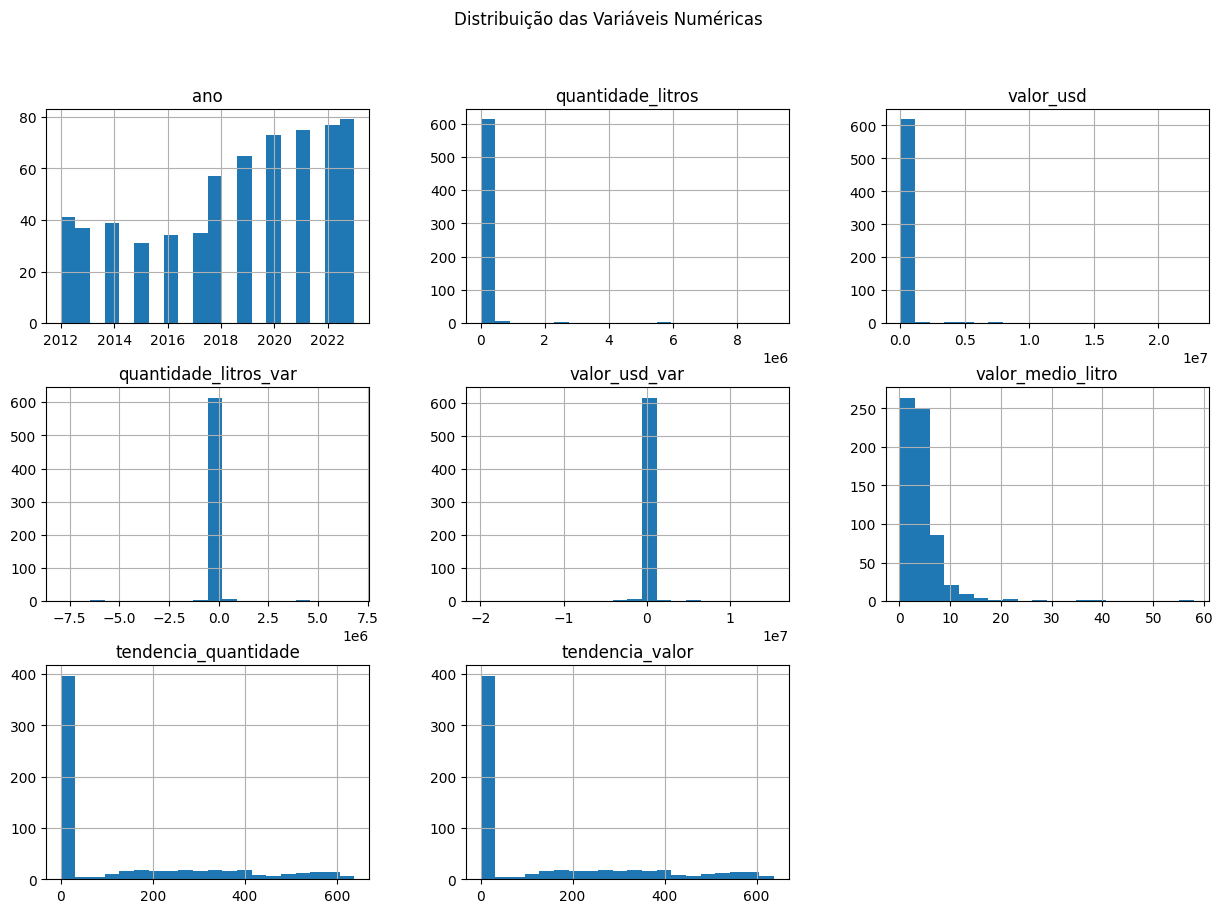

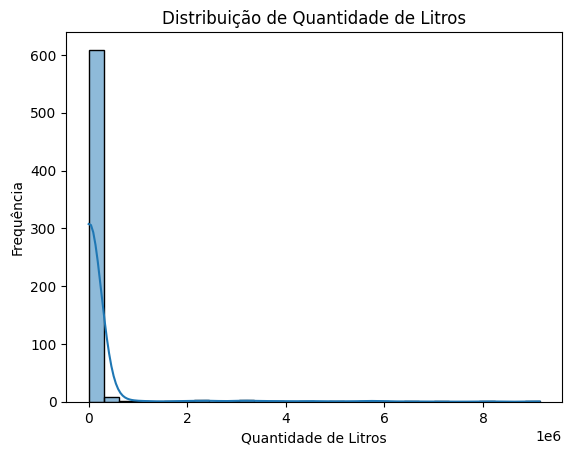

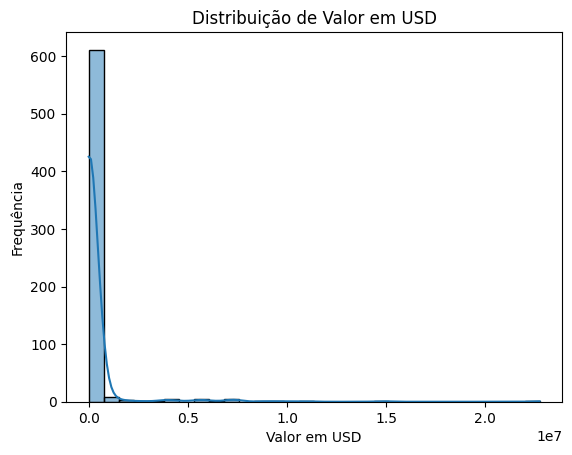

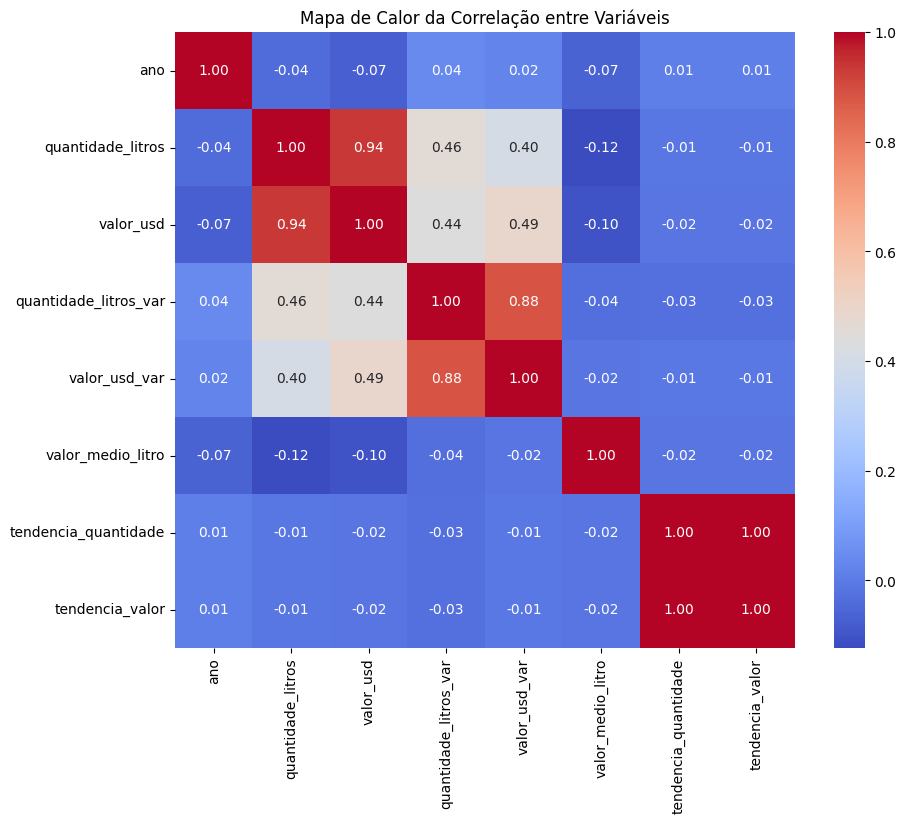

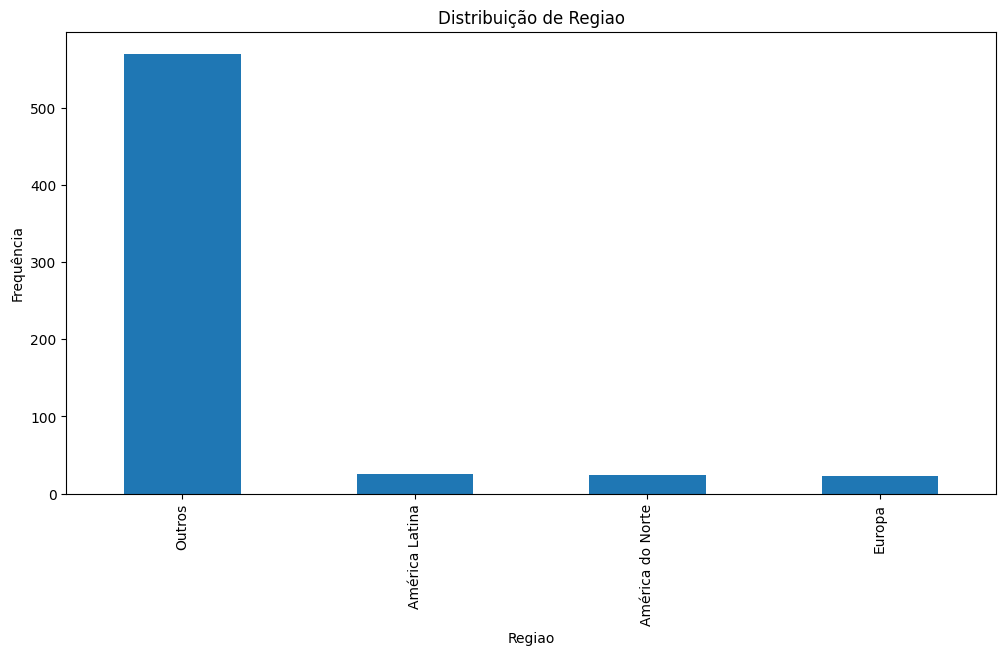

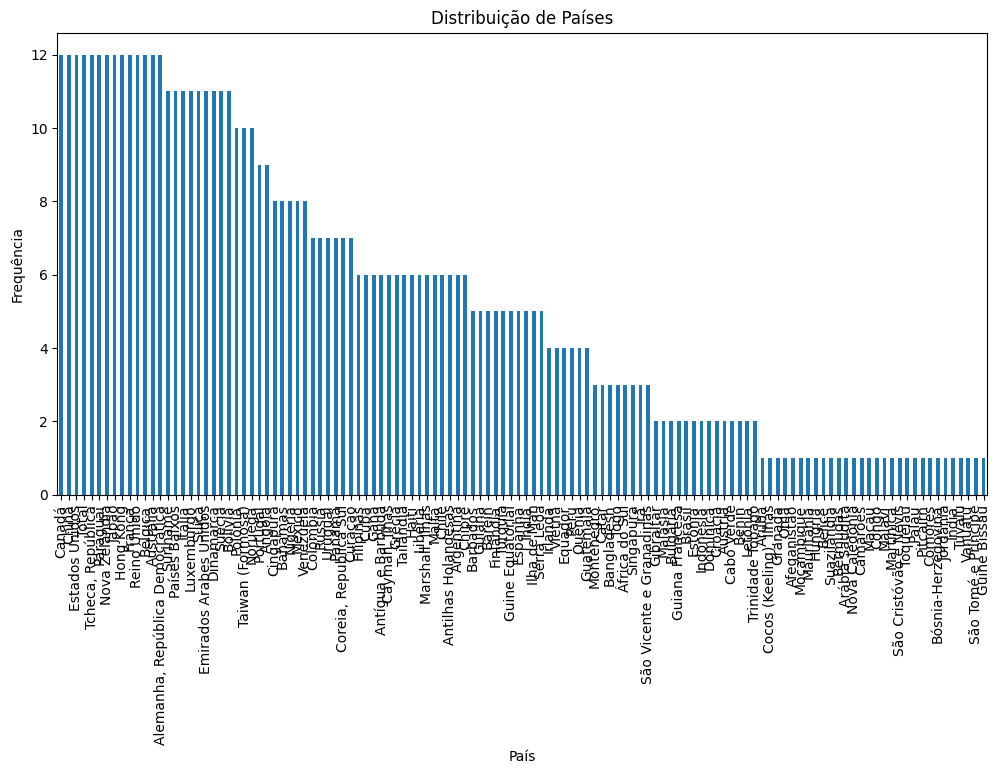

In [25]:
df_clean.head()
# Informações gerais sobre o DataFrame
df_clean.info()

# Estatísticas descritivas
df_clean.describe()

# Verificar a quantidade de valores nulos em cada coluna
df_clean.isnull().sum()


df_clean['ano'].value_counts()
df_clean['pais'].value_counts()


# Substituir valores infinitos por NaN
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remover linhas com valores NaN
df_clean.dropna(inplace=True)

# Histograma para cada coluna numérica
df_clean.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribuição das Variáveis Numéricas")
plt.show()

# Distribuição da coluna 'quantidade_litros'
sns.histplot(df_clean['quantidade_litros'], kde=True, bins=30)
plt.title("Distribuição de Quantidade de Litros")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Frequência")
plt.show()

# Distribuição da coluna 'valor_usd'
sns.histplot(df_clean['valor_usd'], kde=True, bins=30)
plt.title("Distribuição de Valor em USD")
plt.xlabel("Valor em USD")
plt.ylabel("Frequência")
plt.show()

# Matriz de correlação
df_numeric = df_clean.select_dtypes(include=['number'])
# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Mapa de calor para visualizar a correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Calor da Correlação entre Variáveis")
plt.show()

# Contagem de valores únicos na coluna 'regiao'
df_clean['regiao'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title("Distribuição de Regiao")
plt.xlabel("Regiao")
plt.ylabel("Frequência")
plt.show()


# Contagem de valores únicos na coluna 'pais'
df_clean['pais'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title("Distribuição de Países")
plt.xlabel("País")
plt.ylabel("Frequência")
plt.show()



Correlação entre quantidade_litros e valor_usd: 0.94


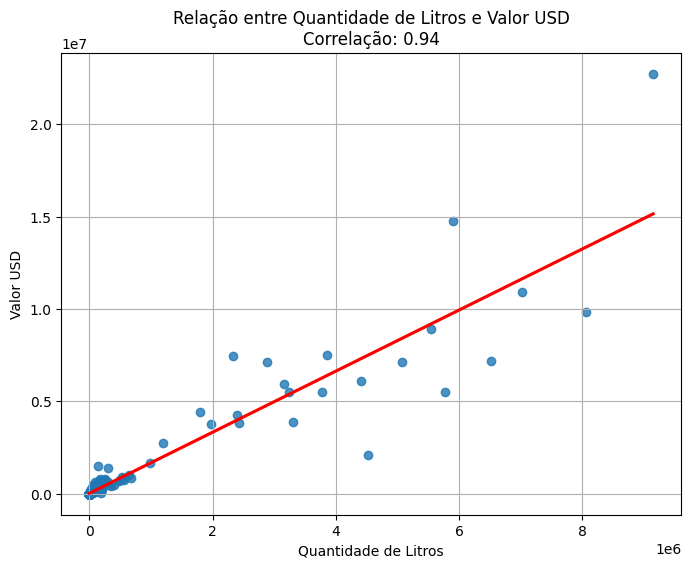

In [26]:
# Calcular a correlação
correlacao = df_clean[['quantidade_litros', 'valor_usd']].corr().iloc[0, 1]
print(f"Correlação entre quantidade_litros e valor_usd: {correlacao:.2f}")

# Scatter plot com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(data=df_clean, x='quantidade_litros', y='valor_usd', ci=None, line_kws={"color": "red"})
plt.title(f"Relação entre Quantidade de Litros e Valor USD\nCorrelação: {correlacao:.2f}")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Valor USD")
plt.grid()
plt.show()

In [27]:
df_clean.head()

,ano,pais,quantidade_litros,valor_usd,quantidade_litros_var,valor_usd_var,valor_medio_litro,regiao,tendencia_quantidade,tendencia_valor
2,2016,Canadá,13711.0,71096.0,0.0,0.0,5.185326,América do Norte,2.0,2.0
6,2016,China,134106.0,499622.0,0.0,0.0,3.725575,Outros,6.0,6.0
8,2016,Cingapura,5445.0,13199.0,0.0,0.0,2.424059,Outros,8.0,8.0
13,2016,"Coreia, Republica Sul",8.0,20.0,0.0,0.0,2.500000,Outros,13.0,13.0
18,2016,Cuba,63741.0,69830.0,0.0,0.0,1.095527,Outros,18.0,18.0


In [28]:
# Definir as variáveis de entrada (X) e as variáveis de saída (y)
X = df_clean.drop(columns=['quantidade_litros','valor_usd'])  # Remover as colunas de saída
y = df_clean[['quantidade_litros', 'valor_usd']]  # Colunas de saída



In [29]:
X.head()

,ano,pais,quantidade_litros_var,valor_usd_var,valor_medio_litro,regiao,tendencia_quantidade,tendencia_valor
2,2016,Canadá,0.0,0.0,5.185326,América do Norte,2.0,2.0
6,2016,China,0.0,0.0,3.725575,Outros,6.0,6.0
8,2016,Cingapura,0.0,0.0,2.424059,Outros,8.0,8.0
13,2016,"Coreia, Republica Sul",0.0,0.0,2.500000,Outros,13.0,13.0
18,2016,Cuba,0.0,0.0,1.095527,Outros,18.0,18.0


In [30]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


# Exibir as dimensões dos conjuntos de treino e teste
print(f"Dimensões do conjunto de treino X: {X_train.shape}")
print(f"Dimensões do conjunto de teste X: {X_test.shape}")
print(f"Dimensões do conjunto de treino y: {y_train.shape}")
print(f"Dimensões do conjunto de teste y: {y_test.shape}")


Dimensões do conjunto de treino X: (514, 8)
Dimensões do conjunto de teste X: (129, 8)
Dimensões do conjunto de treino y: (514, 2)
Dimensões do conjunto de teste y: (129, 2)


## MODEL TRAINING

#### TRAINING (RANDOM FOREST REGRESSOR)

In [31]:

# Tratamento de dados faltantes e codificação de variáveis categóricas
numeric_features = ['ano']
categorical_features = ['pais']


# Pipeline para variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar variáveis categóricas
])


# Combinar os transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [32]:
# Criar o modelo de Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)


# Pipeline completo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pais'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

#### EVALUATE MODEL

In [33]:
predictions = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"Mean Squared Error para : {mse}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score para : {r2}")


Mean Squared Error para : 355440678648.4831
MAPE: 114.84%
R2 Score para : 0.7312441253623239


### PREDICT

In [34]:

novo_pais = 'Venezuela'

# Fazer previsões 
new_data = pd.DataFrame({
    'pais': [novo_pais]
})

# Fazer a previsão
predicao = model.predict(new_data)

# Garantir que valores negativos sejam exibidos como zero
quantidade_prevista = predicao[0][0]  # Quantidade de Litros
valor_previsto = predicao[0][1]  # Valor em USD

# Garantir que valores negativos sejam exibidos como zero
quantidade_prevista = max(quantidade_prevista, 0)
valor_previsto = max(valor_previsto, 0)

# Exibir os resultados
print(f"Previsão de exportacao para o país {novo_pais}:")
print(f"Quantidade Prevista: {quantidade_prevista:,.2f}")
print(f"Valor em USD Previsto: {valor_previsto:,.2f}")


Previsão de exportacao para o país Venezuela:
Quantidade Prevista: 27,139.84
Valor em USD Previsto: 42,302.77


### SAVE MODEL

In [35]:

# Obter o diretório atual do notebook
notebook_dir = os.getcwd()
parent_dir_two_levels_up = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir))
save_dir = os.path.join(parent_dir_two_levels_up, 'ml-model', 'production')
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'modelo_exportacao.pkl')
# Salvar o modelo treinado e o 
joblib.dump(model, model_path)
print(f"Modelo salvo em: {model_path}")

Modelo salvo em: /home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-vitivinicultura-api/ml-model/production/modelo_exportacao.pkl


In [36]:
pais_count = df_clean['pais'].value_counts()
pais_com_poucas_ocorrencias = pais_count[pais_count == 1].index

# Substituir esses países por "Outros"
df_clean['pais'] = df_clean['pais'].replace(pais_com_poucas_ocorrencias, 'Outros')

df_clean['pais'].value_counts()

pais
Outros       30
China        12
Hong Kong    12
França       12
Canadá       12
             ..
Benin         2
Indonésia     2
Letônia       2
Gibraltar     2
Malásia       2
Name: count, Length: 93, dtype: int64